# Grafteori - svenska jarnvagsnatet
Erik Hallberg, Alvin Lind, Emilio Youssef och Mohammad Kajno

**Prerequisites**
* `pip3 install requirements.txt`

In [2]:
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from ipywidgets import widgets

## Loading the data

In [3]:
# load the data
dataset = gpd.read_file('./data.gpkg')
print('dataset size: ', dataset.shape[0])
print('dataset columns: ', dataset.columns.values)

dataset size:  1456
dataset columns:  ['TxID' 'StrNr' 'Strak' 'BdlNr' 'Bandel' 'Forbind_1' 'PlSignFr' 'PlNamnFr'
 'PlSignTi' 'PlNamnTi' 'AntalSpar' 'Elektrif' 'Infraforv' 'UHDist' 'TrSys'
 'TComr' 'Status' 'BdlSeq' 'geometry']


In [4]:
# load the dataset containg the information if a passenger can board a train
stations = gpd.read_file('./stations.gpkg')
stations = stations[stations.PlTyp != 'dp*']

print('dataset size: ', stations.shape[0])
print('dataset columns: ', stations.columns.values)
# the column ResUtbyte is the one we are interested in below:

dataset size:  1611
dataset columns:  ['OBJECTID' 'TplKod' 'Sign' 'SignTxt' 'PlNamn' 'PlTyp' 'PltypBesk'
 'Tillh_dpd' 'Tillh_dp_lp' 'PlStatus' 'ResUtbyte' 'Lastpl' 'Hamn'
 'Kombiterm' 'Northing' 'Easting' 'Latitud' 'Longitud' 'Moh' 'Strak'
 'Bandel' 'Kmtalfr' 'Kmtalti' 'Region' 'TL' 'UH' 'Dignitet' 'Skapad'
 'geometry']


In [5]:
# load map of sweden (used for plotting)
sweden = gpd.read_file('./swedish_municipalities.geojson')
sweden = sweden.to_crs('EPSG:3006')

## Filtering and creation of the dataset

In [6]:
filtered_dataset = dataset.copy()

### Removing stations where a passenger cannot board a train

In [7]:
remove_list = stations[stations.ResUtbyte != 'j'].SignTxt.values
for to_remove in filtered_dataset[(filtered_dataset.PlSignFr.isin(remove_list))].PlSignFr.unique():

    station = stations[stations.SignTxt == to_remove] 

    matched = stations[stations.Tillh_dp_lp == station.PlNamn.values[0]]
    if matched.shape[0] != 0:
        if matched.ResUtbyte.values[0] == 'j':
            continue                   
        
    # find rows with station that should be removed
    pre_row = filtered_dataset[(filtered_dataset.PlSignTi == to_remove)]
    suc_row = filtered_dataset[(filtered_dataset.PlSignFr == to_remove)]

    filtered_dataset.loc[pre_row.index,'PlSignTi'] = suc_row.PlSignTi.values[0]
    filtered_dataset.loc[pre_row.index,'PlNamnTi'] = suc_row.PlNamnTi.values[0]

    filtered_dataset.drop(suc_row.index, inplace=True, axis=0)

filtered_dataset.head()

,TxID,StrNr,Strak,BdlNr,Bandel,Forbind_1,PlSignFr,PlNamnFr,PlSignTi,PlNamnTi,AntalSpar,Elektrif,Infraforv,UHDist,TrSys,TComr,Status,BdlSeq,geometry
2,T230282,8.0,Norra stambanan,217.0,Bollnäs-Ljusdal,Ab-Vl,Ab,Arbrå,Vl,Vallsta,1.0,Ja,Trafikverket infrastruktur,Mitt,sysH,Gä,Öppen,217104.0,"LINESTRING (573518.164 6816036.145, 573517.398..."
8,T230195,99.0,Inlandsbanan,161.0,(Gällivare)-(Arvidsjaur),Ajr-Nkr,Ajr,Arvidsjaur,Nkr,Norra Kikkejaur,1.0,Nej,Inlandsbanan AB,IBAB,sysM,Gä,Öppen,161101.0,"LINESTRING (692144.289 7280445.156, 692142.397..."
9,T230031,21.0,Malmbanan,111.0,(Peuravaara)-Riksgränsen-(Björnfjell),Ak-Bln,Ak,Abisko östra,Bln,Björkliden,1.0,Ja,Trafikverket infrastruktur,Nord,sysH,Bdn,Öppen,111110.0,"LINESTRING (657624.433 7586639.317, 657620.394..."
11,T231056,74.0,(Alvhem) - Lilla Edet,666.0,(Alvhem)-Lilla Edet,Alh-Löö,Alh,Alvhem,Let,Lilla Edet,1.0,Nej,Trafikverket infrastruktur,Väst,sysS,G,Öppen,666101.0,"LINESTRING (332165.875 6433556.851, 331653.000..."
12,T230989,11.0,Norge-/Vänerbanan med Nordlänken,635.0,Öxnered-(Älvängen),Alh-Än,Alh,Alvhem,Än,Älvängen,2.0,Ja,Trafikverket infrastruktur,Väst,sysH,G,Öppen,635106.0,"LINESTRING (332165.875 6433556.851, 332165.685..."


### Creating the graph

In [18]:
df = filtered_dataset[['PlSignFr', 'PlSignTi']]

The connections in the dataset does only go one way. Here we extend the dataset with "mirrored" copy of itself.

In [19]:
df = pd.concat([df, pd.DataFrame(data=df[['PlSignTi', 'PlSignFr']].values, columns=['PlSignFr', 'PlSignTi'])])
df

,PlSignFr,PlSignTi
2,Ab,Vl
8,Ajr,Nkr
9,Ak,Bln
11,Alh,Let
12,Alh,Än
...,...,...
770,Sea,Övn
771,Båp,Övn
772,Thn,Öx
773,Vg,Öx


### Creating the adjacency matrix

In [20]:
adj_matrix = pd.crosstab(df.PlSignFr, df.PlSignTi)
adj_matrix

PlSignTi,Ab,Aik,Ajr,Ak,Alh,Ar,Arb,Arnc,Arnn,Arns,...,Ökn,Önd,Ör,Örs,Ös,Öso,Öte,Övm,Övn,Öx
PlSignFr,,,,,,,,,,,,,,,,,,,,,
Ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ajr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Öso,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Öte,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Övm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
adj_matrix_numpy = adj_matrix.to_numpy()

## Analysis
### Search algoritm

Select two stations in the dropdown below. Since we removed some stations from the graph all stations that show in the dropdown might not exists in the graph

If you get an error, in the cell below the dropdowns, try changing the stations. 
Ex to try: Eskilstuna => Vasteras

In [22]:
from_w = widgets.Combobox(
    placeholder='Choose ',
    options=stations.PlNamn.to_list(),
    description='Fran',
    ensure_option=True,
    disabled=False
)

to_w = widgets.Combobox(
    placeholder='Choose ',
    options=stations.PlNamn.to_list(),
    description='Till',
    ensure_option=True,
    disabled=False
)

display(from_w)
display(to_w)


Combobox(value='', description='Fran', ensure_option=True, options=('Vinnö', 'Triabo', 'Totebo', 'Lundsbrunn',…

Combobox(value='', description='Till', ensure_option=True, options=('Vinnö', 'Triabo', 'Totebo', 'Lundsbrunn',…

In [23]:
from_station = stations[stations.PlNamn == from_w.value].Sign.values[0]
to_station = stations[stations.PlNamn == to_w.value].Sign.values[0]

cols = adj_matrix.columns.to_list()

from_index = cols.index(from_station)
to_index = cols.index(to_station)

ajdc = adj_matrix_numpy.copy()
n = 1

non_zero = np.argwhere(ajdc[from_index, :] != 0)


searched = [[]] 

for i in non_zero:
    searched[0].append(cols[i[0]])

while ajdc[from_index, to_index] == 0: 
  
    n+=1
    
    ajdc = np.linalg.matrix_power(adj_matrix_numpy, n)
    non_zero = np.argwhere(ajdc[from_index, :] != 0)
    searched.append([])
    for i in non_zero:
        searched[n-1].append(cols[i[0]])
    
non_zero = np.argwhere(ajdc[from_index, :] != 0)

for i in non_zero:
        searched[n-1].append(cols[i[0]])


print(n)

IndexError: index 0 is out of bounds for axis 0 with size 0

This cell creates a animation of the search algoritm. Saved as a gif

NameError: name 'searched' is not defined

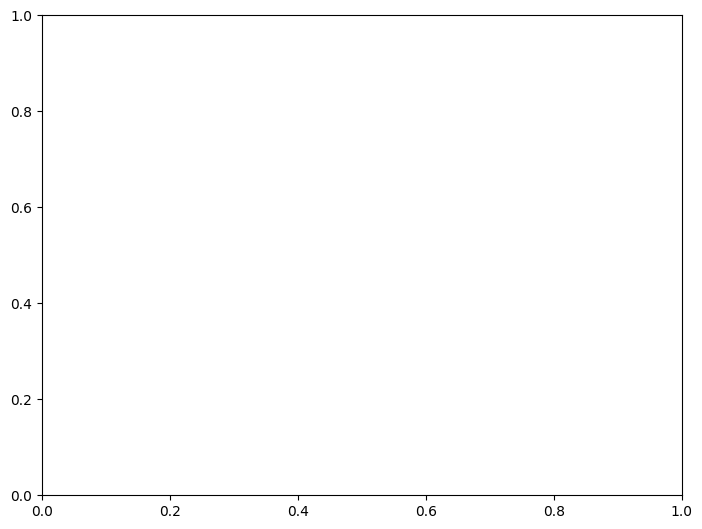

In [24]:
fig, ax = plt.subplots()

fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

def init():
    sweden.geometry.plot(ax=ax, zorder=1)

def animate(i):
    k = stations[stations.Sign.isin(searched[i])]
    k.geometry.plot(ax=ax, zorder=2)

anim = FuncAnimation(fig, animate, init_func=init,interval=200,repeat_delay=300, frames=len(searched))
anim.save(f'{from_station}-{to_station}.gif')

### Finding the "jarnvagsknutar"

<Axes: >

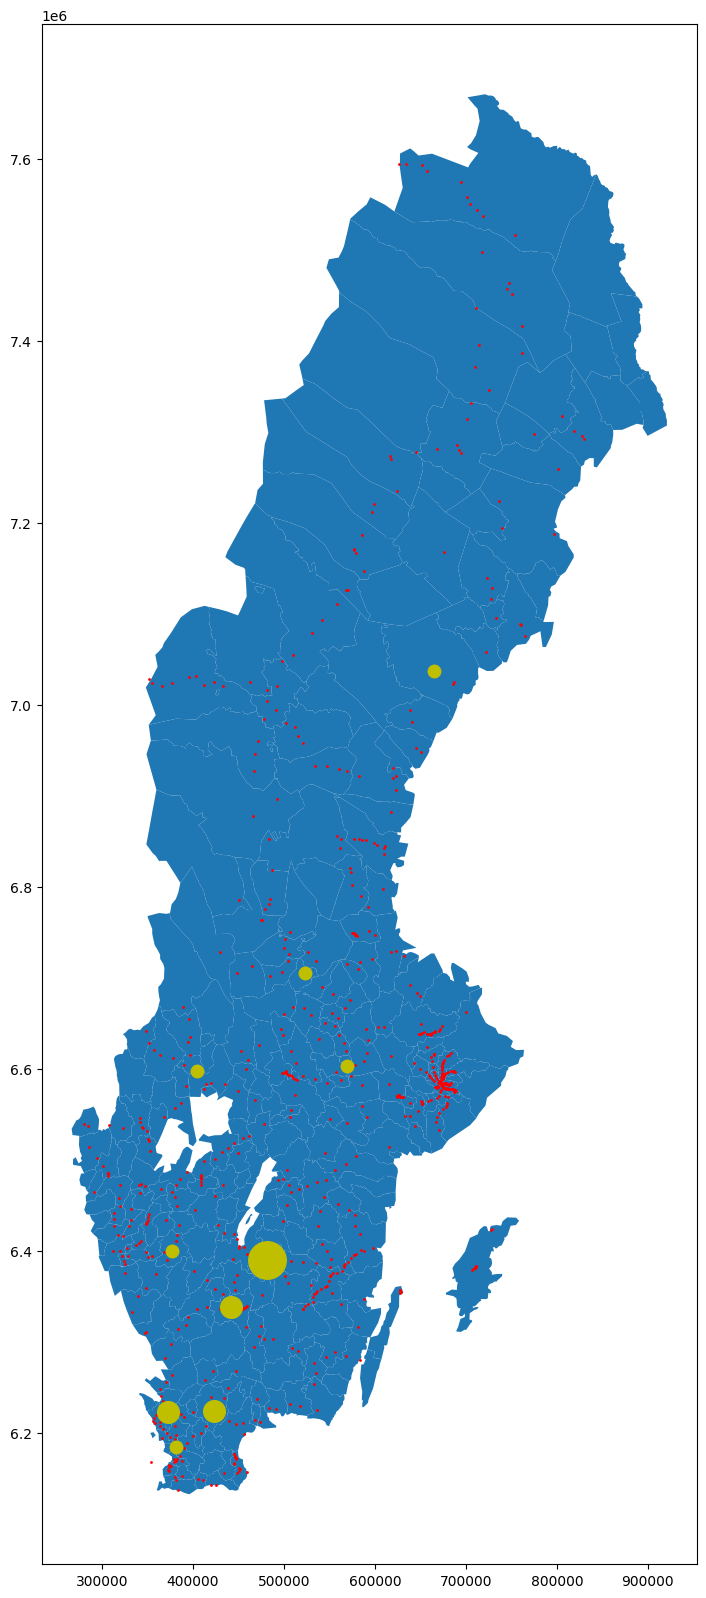

In [25]:
n = 1
result = np.linalg.matrix_power(adj_matrix_numpy, n)

# Räkna antalet icke-noll element i varje rad
non_zero_counts = np.count_nonzero(result, axis=1)

# Hämta indexen för raderna med flest icke-noll element (ändra 10 till önskat antal stationer)
top_indices = np.argsort(non_zero_counts)[::-1][:10]

fig, ax = plt.subplots(figsize=(30, 20))
sweden.geometry.plot(ax=ax)
for index in top_indices:
    station = adj_matrix.index[index]  
    filtered_station = stations[stations.Sign == station]  # Filtrerar baserat på 'Sign' kolumnen
    count = non_zero_counts[index]
    filtered_station.geometry.plot(ax=ax, markersize=3**count, zorder=2, color='y') 
stations[stations.Sign.isin(adj_matrix.columns)].geometry.plot(ax=ax, markersize=1, color='r', zorder=1)

In [26]:
# Upphöj till en given potens (här: n = 1)
n = 1
result = np.linalg.matrix_power(adj_matrix_numpy, n)

# Räkna antalet icke-noll element i varje rad
non_zero_counts = np.count_nonzero(result, axis=1)

# Hämta indexen för raderna med flest icke-noll element (ändra 10 till önskat antal stationer)
top_indices = np.argsort(non_zero_counts)[::-1][:10]

# Visa de stationer med flest anslutningar
print("Stationer med flest anslutningar:")
for index in top_indices:
    station = adj_matrix.index[index]  
    filtered_station = stations[stations.Sign == station]  # Filtrerar baserat på 'Sign' kolumnen
    count = non_zero_counts[index]
    print(f"Station: {station}, Antal anslutningar: {count}")
    
    # Hämtar kolumnen 'PlNamn' för varje filtrerad station och skriver ut den
    if not filtered_station.empty:
        pinamn_values = filtered_station['PlNamn'].values.tolist()
        print(f"PINamn för station {station}: {pinamn_values}")
    else:
        print(f"Ingen information hittades för station {station}")



Stationer med flest anslutningar:
Station: N, Antal anslutningar: 6
PINamn för station N: ['Nässjö central']
Station: V, Antal anslutningar: 5
PINamn för station V: ['Värnamo']
Station: Hm, Antal anslutningar: 5
PINamn för station Hm: ['Hässleholm']
Station: Åp, Antal anslutningar: 5
PINamn för station Åp: ['Åstorp']
Station: Kbä, Antal anslutningar: 4
PINamn för station Kbä: ['Kolbäck']
Station: Blgc, Antal anslutningar: 4
PINamn för station Blgc: ['Borlänge central']
Station: Msl, Antal anslutningar: 4
PINamn för station Msl: ['Mellansel']
Station: Bsc, Antal anslutningar: 4
PINamn för station Bsc: ['Borås central']
Station: Kil, Antal anslutningar: 4
PINamn för station Kil: ['Kil']
Station: Kg, Antal anslutningar: 4
PINamn för station Kg: ['Kävlinge']
